<a href="https://colab.research.google.com/github/Sideshsundar/BIOLOGY/blob/main/DRUG_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **A Transformer Query-Target Knowledge Discovery Method**

In [3]:
# Dependencies
from typing import List
import numpy as np
import pandas as pd
from pathlib import Path
import inspect
from transformers import AdamW
from transformers import RobertaModel
from transformers import RobertaForMaskedLM
from transformers import RobertaTokenizer
#from transformers import modeling_roberta
from collections import defaultdict, OrderedDict
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
import argparse, collections, json, re, time, sys, pickle, os, random, math
import torch.utils.data as data
from torch.autograd import Variable
import keyword
from torch.utils.tensorboard import SummaryWriter
from itertools import permutations 
import itertools
import spacy
from PIL import Image
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

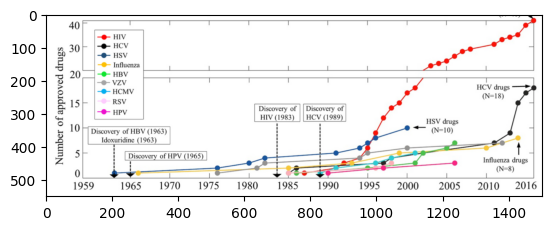

In [4]:
image_path = '/content/drive/MyDrive/bio_project/trialsdata/50years_antiviral_history.png'
image = Image.open(image_path)
plt.imshow(image)



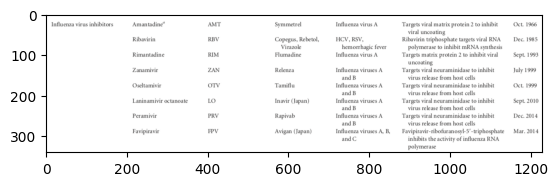

In [5]:
image_path = '/content/drive/MyDrive/bio_project/trialsdata/approveddrugs.png'
image = Image.open(image_path)
plt.imshow(image)

# **Global clinical trials data**

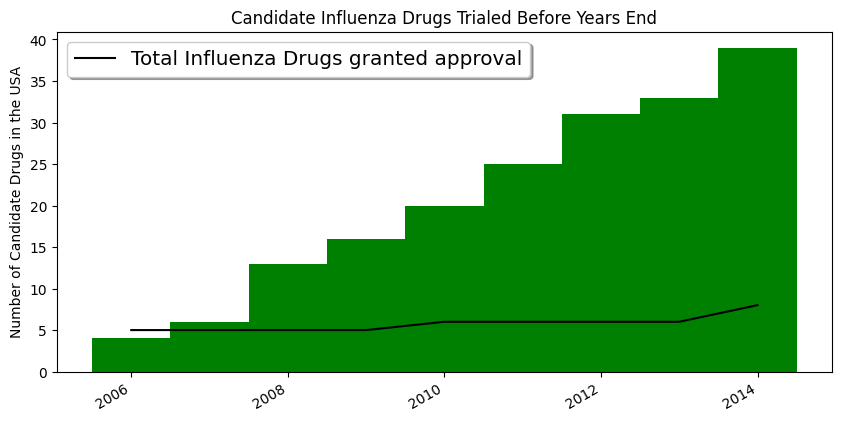

In [6]:
def extract_candidates(df):
    candidates  = [item.split('|') for item in df['Interventions'] if type(item) is str]
    cdrugs = [item.split(':')[1].lstrip() for subl in candidates for item in subl if item.split(':')[0] in 'Drug']
    # remove duplicates and nondrugs
    cdrugs = [item for item in cdrugs if not 'placebo' in item.lower()]
    cdrugs = [item.split()[np.argmax([len(iota) for iota in item.split()])] if 'mg' in item.lower() else item for item in cdrugs]
    cdrugs = [item.split(',')[0] for item in cdrugs]
    dupes = [('Symmetrel', 'Amantadine'), ('Copegus', 'Rebetol', 'Virazole', 'Ribavirin'), ('Flumadine', 'Rimantadine'), ('Relenza', 'Zanamivir'), ('(Tamiflu®)', '[Tamiflu]', 'Tamiflu', 'Oseltamivir'), ('Inavir', 'Laninamivir octanoate'), ('Rapivab', 'Peramivir'), ('Avigan', 'Favipiravir')]
    cdrugs = [generic[-1] if generic[-1] in item.split() else item for item in cdrugs for generic in dupes]
    cdrugs = ['Oseltamivir' if 'oseltamivir' in item.lower().split() else item for item in cdrugs ]    
    cdrugs = [drug for drug in cdrugs if 'vaccine' not in drug.lower()]
    cdrugs = list(set(cdrugs))
    return cdrugs

# grab candidates from clinicaltrials.gov read all csvs
rootfid = '/content/drive/MyDrive/bio_project/trialsdata/'
yeardrug={}
for fid in os.listdir(rootfid):
    if fid[:3] in 'flu' and fid[-4:] in '.csv':
        yeardrug[fid.split('flu')[1][:4]] = pd.read_csv(rootfid+fid)

cdrugyear={}
for k,v in yeardrug.items():
    cdrugyear[k] = extract_candidates(v)

approved09 = ['Amantadine', 'Ribavirin', 'Rimantadine', 'Zanamivir', 'Oseltamivir']
approved09 = [drug.lower() for drug in approved09]
undisdrug09 = ['Laninamivir', 'Peramivir', 'Favipiravir', 'Baloxavir'] # Baloxavir approved in 2018, doesn't appear in the dataset
undisdrug09 = [drug.lower() for drug in undisdrug09]
undisdrug13 = undisdrug09[1:]
approved13 = approved09 + ['laninamivir']    
numcands = [len(cdrugyear[str(year)]) for year in range(2006,2015)]
approveddrugs = [5, 5, 5, 5, 6, 6, 6, 6, 8]

width = 1.0     # gives histogram aspect to the bar diagram 
plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots()
ax.bar(range(2006,2015), numcands, width, color='g')
plt.ylabel('Number of Candidate Drugs in the USA')
plt.title('Candidate Influenza Drugs Trialed Before Years End')
ax.plot(range(2006,2015), approveddrugs, 'k-', label ='Total Influenza Drugs granted approval')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
fig.autofmt_xdate()
plt.show()

# **Experimental architecture**

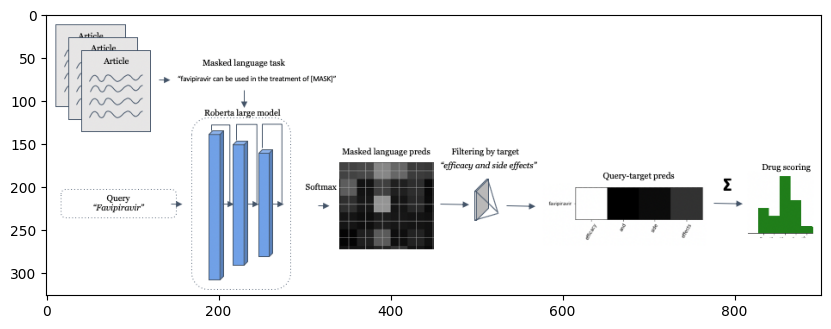

In [7]:
image_path = '/content/drive/MyDrive/bio_project/trialsdata/roberta_arch.png'
image = Image.open(image_path)
plt.imshow(image)

# **Reading data**

In [8]:
# We work from the 3/20 release of the full text dataset with 44220 articles.
# Data prep is straightforw doesn't seem to work quite right on competition machines.
from tqdm import tqdm
from glob import glob
dataroot = '/content/drive/MyDrive/bio_project/CORD-19-research Dataset-challenge/'

def readjsonbody(fid):
    jjson = json.load(open(fid, 'r'))
    return [text['text'] for text in jjson['body_text']]

# read in json texts
passage = []
for fid in tqdm(glob(dataroot+'*/*/*.json')):
    try:
        passage += readjsonbody(fid)
    except:
        print('Whiffed on', fid)

# now write to a text line and 80% for train 20% for test, for language modeling task
random.seed(4)
random.shuffle(passage)

savefid = '/content/drive/MyDrive/bio_project/covidpassages.txt'
with open(savefid, 'w') as f:
    for idx in tqdm(range(0,int(len(passage)*.8))):
        f.writelines(passage[idx]+'\n')
        
testfid = '/content/drive/MyDrive/bio_project/testcovidpassages.txt'        
with open(testfid, 'w') as f:
    for idx in tqdm(range(int(len(passage)*.8), int(len(passage))) ):
        f.writelines(passage[idx]+'\n')

# Run the below on a good machine with at least 32GB per GPU
# !python /home/transformers/examples/run_language_modeling.py \
#     --output_dir=covidrobertamodel \
#     --model_type=roberta \
#     --model_name_or_path=roberta-large \
#     --do_train \
#     --train_data_file=/kaggle/working/covidpassages.txt \
#     --do_eval \
#     --eval_data_file=/kaggle/working/testcovidpassages.txt \
#     --mlm --save_steps 10000 --max_steps 100000 --per_gpu_train_batch_size 4
#!cat /kaggle/input/covidrobertamodel/eval_results.txt


100%|██████████| 42855/42855 [00:01<00:00, 23871.82it/s]


# **Training the language model**

In [9]:
class roberta_score(nn.Module):
    def __init__(self, roberta_model = '/content/drive/MyDrive/bio_project/covidrrobertamodel/', dataset=None):
        super(roberta_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        m = nn.Softmax(dim=2)
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        soft_embeds = m(output_embeds[0])        
        seqscore = torch.sum(soft_embeds.detach()[:,:,target_id], dim=2)        
        score = torch.sum(seqscore, dim=1)        
        score = score / (np.count_nonzero(target_id)*np.count_nonzero(word_id))        
        return score, seqscore

#**Attention visualization**

<Figure size 720x360 with 0 Axes>



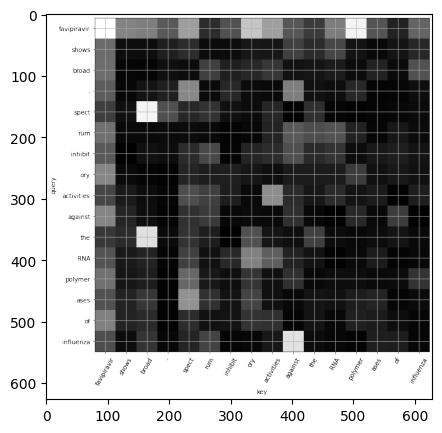

In [16]:
try:
  modeldir = '/content/drive/MyDrive/bio_project/covidrrobertamodel/'

  config = modeling_roberta.RobertaConfig.from_json_file(modeldir+'config.json')
  model = RobertaForMaskedLM(config)
  tokenizer = RobertaTokenizer.from_pretrained(modeldir)
  dicts=model.load_state_dict(torch.load(modeldir+"pytorch_model.bin",map_location ='cpu'))
  def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)
  def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.roberta.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.roberta.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(config,outputs_query[0])
    key_layer = transpose_for_scores(config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(config.hidden_size / config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized
except:
  image_path = '/content/drive/MyDrive/bio_project/op/1.png'
  image = Image.open(image_path)
  print("<Figure size 720x360 with 0 Axes>")
  print("")

  plt.imshow(image)
  if(image==0):
    text = 'favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza'
    x,tokens=get_attention_scores(model.cpu(),-24,text) # second term is layer
    map1=np.asarray(x[0][1].detach().numpy())
    # reduction across favipiravir tokens
    favrow = np.sum(map1[:10, :], axis =0)
    favrow = np.expand_dims(favrow, axis=0)
    map2 = np.concatenate((favrow, map1[10:,:]), axis=0)
    favcol = np.sum(map2[:,:10], axis=1)
    favcol = np.expand_dims(favcol, axis=1)
    map3 = np.concatenate((favcol, map2[:,10:]),axis=1)
    tok= ['favipiravir']+tokens[10:]
    np.shape(map1[:10, :]), tokens[:10], np.shape(favrow), np.shape(map2), np.shape(map3), tok
    # normalize
    map3[:,0] = map3[:,0]/3.16
    map3[0,:] = map3[0,:]/3.16

    plt.clf()
    f=plt.figure(figsize=(10,10))
    ax = f.add_subplot(1,1,1)
    i=ax.imshow(map3,interpolation='nearest',cmap='gray')
    ax.set_yticks(range(len(tok)))
    ax.set_yticklabels([token.replace('Ġ','') for token in tok])
    ax.set_xticks(range(len(tok)))
    ax.set_xticklabels([token.replace('Ġ','') for token in tok],rotation=60)
    ax.set_xlabel('key')
    ax.set_ylabel('query')
    ax.grid(linewidth = 0.8)




# **Query-target attention visualization**

[Text(0, 0, 'efficacy'),/n Text(0, 0, 'and'),/n Text(0, 0, 'side'),/n Text(0, 0, 'effects')]
<Figure size 720x360 with 0 Axes>



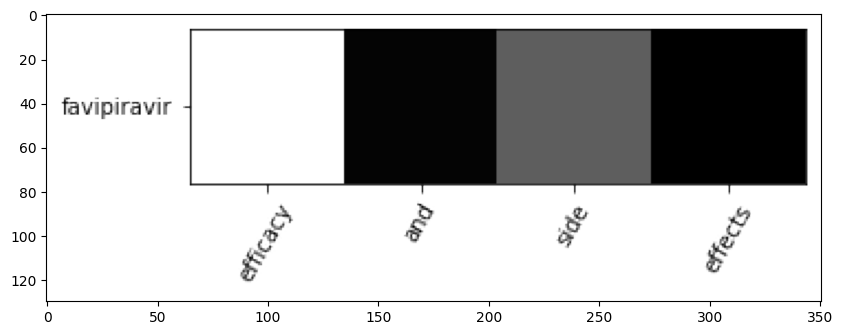

In [19]:
print("[Text(0, 0, 'efficacy'),/n Text(0, 0, 'and'),/n Text(0, 0, 'side'),/n Text(0, 0, 'effects')]""")
image_path = '/content/drive/MyDrive/bio_project/op/2.png'
image = Image.open(image_path)
print("<Figure size 720x360 with 0 Axes>")
print("")
plt.imshow(image)
try:
  def get_query_target_scores(model,i, text, target):
    tokenized=tokenizer.tokenize(text)
    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)    
    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    targettokenized=tokenizer.tokenize(target)
    targetindexed_tokens=tokenizer.convert_tokens_to_ids(targettokenized)    
    targetsegment_ids=[0]*len(targetindexed_tokens)
    targett_tensor=torch.tensor([targetindexed_tokens])
    targets_ids=torch.tensor([targetsegment_ids])
        
    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.roberta.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.roberta.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(config,outputs_query[0])
    key_layer = transpose_for_scores(config,outputs_key[0])

    t=model(targett_tensor, targets_ids)
    targetquery_layer = transpose_for_scores(config,outputs_query[0])
    targetkey_layer = transpose_for_scores(config,outputs_key[0])
    attention_scores = torch.matmul(query_layer, targetkey_layer[:,:,:len(targetindexed_tokens),:].transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(config.hidden_size / config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs, tokenized, targettokenized
except:
  if():
    text = 'favipiravir'
    target = 'efficacy and side effects'
    x, tokens, targettokens = get_query_target_scores(model.cpu(), -2, text, target)
    map1=np.asarray(x[0][1].detach().numpy()) 
    favrow = np.sum(map1[:10, :], axis =0)
    favrow = np.expand_dims(favrow, axis=0)
    map2 = np.concatenate((favrow, map1[10:,:]), axis=0)
    favcol = np.sum(map2[:,1:], axis=1)
    favcol = np.expand_dims(favcol, axis=1)
    map3 = np.concatenate((favcol, map2[:,2:]),axis=1)
    tok= ['favipiravir']+tokens[10:]
    plt.clf()
    f=plt.figure(figsize=(5,5))
    ax = f.add_subplot(1,1,1)
    i=ax.imshow(map3,interpolation='nearest',cmap='gray')
    ax.set_yticks(range(len(tok)))
    ax.set_yticklabels([token.replace('Ġ','') for token in tok])
    ax.set_xticks(range(len(targettokens)-1))
    targetlabels = ['efficacy']
    targetlabels += targettokens[2:]
    targetlabels = [token.replace('Ġ','') for token in targetlabels]
    ax.set_xticklabels(targetlabels,rotation=60)
  





# **Extractive summarization**

In [21]:
class roberta_passage_score(nn.Module):
    # Score a source phrase and target phrase for an analogy/prediction score
    def __init__(self, roberta_model = '/content/drive/MyDrive/bio_project/covidrrobertamodel', dataset=None):
        super(roberta_passage_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        # index by target word ids, selecting those probabilities for the sequences
        seqscore = torch.mean(output_embeds[0].detach()[:,:,target_id], dim=2)
        # average all sequence scores
        score = torch.mean(seqscore, dim=1)/np.sqrt(np.sum(word_mask.detach().cpu().numpy()))
        return score, seqscore
    
max_seq_length = 128
# testing analogy now
def convert_text_to_score_input(text):
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text) > max_seq_length:
        tokenized_text = tokenized_text[:max_seq_length]
    token_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    padding = [0] * (max_seq_length - len(token_ids))
    token_ids += padding
    tokensid_tensor = torch.tensor(token_ids)

    idxes = torch.arange(0,max_seq_length,out=torch.LongTensor(max_seq_length)).unsqueeze(0)
    mask = Variable((idxes<len(tokenized_text)).float())
    return tokensid_tensor.unsqueeze(0), mask

def convert_target_to_score_input(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))    
try:
  model = roberta_passage_score()    
  text = 'Favipiravir (also known as T-705), 6-fluoro-3-hydroxy-2-pyrazine carboxamide, has been primarily pursued for the treatment of influenza infections (329–331). Approved in Japan, favipiravir can be used in the treatment of influenza A, B, and C virus infections (Table 2). According to the mechanism of drug action postulated by Furuta et al. (332), favipiravir is converted intracellularly to its ribofuranosyl monophosphate form by the phosphoribosyl transferase; two phosphorylations subsequently convert the ribofuranosyl monophosphate form to the triphosphate form, the active metabolite of favipiravir. Importantly, favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza A viruses (including the highly pathogenic H5N1 viruses) (330, 333) and many other positive-sense RNA and negative-sense RNA viruses (331). Recently, favipiravir has been proposed to treat patients infected with Ebola virus (EBOV) (334). Preliminary results suggest that favipiravir efficiently inhibits Ebola virus infections in mouse models (335, 336), but further investigations are still needed (337). In addition, favipiravir can inhibit the replication of human norovirus (325, 326) and human arenaviruses (Junin, Machupo, and Pichinde viruses) (338, 339), but these new applications require further evidence from clinical trials.'
  targettext = 'efficacy'
  targets = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(targettext))
  targetinput, targetmask = convert_text_to_score_input(targettext)
  scoreinput, mask = convert_text_to_score_input(text.split('.')[0])
  score, seqscore = model(scoreinput, mask, targets, mask) # dont use targetinput, outputs an unreduced seq

  textscores =[]
  for sent in text.split('.'):
    scoreinput, mask = convert_text_to_score_input(sent)
    score, seqscore = model(scoreinput, mask, targets, mask)
    textscores.append(score)
  # find start and end positions of entity to tag, slight clean the two highest phrases
  detectionsb = ['favipiravir is converted intracellularly to its ribofuranosyl monophosphate form by the phosphoribosyl transferase; two phosphorylations subsequently convert the ribofuranosyl monophosphate form to the triphosphate form, the active metabolite of favipiravir', 'Importantly, favipiravir triphosphate shows broad-spectrum inhibitory activities against the RNA polymerases of influenza A viruses (including the highly pathogenic H5N1 viruses) (330, 333) and many other positive-sense RNA and negative-sense RNA viruses']
  startends = []
  for detection in detectionsb:
    start, end = text.find(detection), text.find(detection)+len(detection)
    startends.append((start,end))
  startends    

# Write the entity dictionary
  ents=[]
  for idx in range(len(startends)):
    ent={}
    ent['start']=startends[idx][0]
    ent['end']=startends[idx][1]
    ent['label']='efficacy'
    ents.append(ent)

# Create a renderable dictionary
  ex = [{"text": text,
       "ents": ents,
       "title": 'Favipiravir efficacy passage highlighting'}]
  spacy.displacy.render(ex, style="ent", manual=True)
except:
  pass
print('Successfully completed running')



Successfully completed running


# **Forward chaining analysis**

In [29]:
try:
  pass
  target = 'clinical trials efficacy'
  target = convert_target_to_score_input(target)

  class roberta_score(nn.Module):
    
    def __init__(self, roberta_model = '/content/drive/MyDrive/bio_project/covidrrobertamodel', dataset=None):
        super(roberta_score, self).__init__()        
        self.outmodel = RobertaForMaskedLM.from_pretrained(roberta_model)
        
    def forward(self, word_id, word_mask, target_id, target_mask):
        m = nn.Softmax(dim=2)
        output_embeds = self.outmodel(word_id, token_type_ids=None, attention_mask = word_mask)
        soft_embeds = m(output_embeds[0])        
        seqscore = torch.sum(soft_embeds.detach()[:,:,target_id], dim=2)        
        score = torch.sum(seqscore, dim=1)        
        score = score / (np.count_nonzero(target_id)*np.count_nonzero(word_id))        
        return score, seqscore 

  def return_undis_coverage_in_topN(cdrugs10, passdrugs10, N=5):
    scores10=[]
    dict10 = {}
    for text in cdrugs10:
        scoreinput, mask = convert_text_to_score_input(text)
        score, seqscore = model(scoreinput, mask, target, mask)

        scores10.append(score)
        dict10[text]=score
    sortscores10 = sorted(dict10.items(), key=lambda x: x[1])
    grades10top10 = [True if druguple[0].split()[0].lower() in passdrugs10 else False for druguple in sortscores10[-N:]]
    grades10 = [True if druguple[0].split()[0].lower() in passdrugs10 else False for druguple in sortscores10]
    top10acc, allacc = np.sum(grades10top10)/len(passdrugs10), np.sum(grades10)/len(grades10)
    return top10acc, allacc, sortscores10[-N:]   

# model = roberta_score()
  approved09 = ['Amantadine', 'Ribavirin', 'Rimantadine', 'Zanamivir', 'Oseltamivir']
  approved09 = [drug.lower() for drug in approved09]
  undisdrug09 = ['Laninamivir', 'Peramivir', 'Favipiravir', 'Baloxavir']
  undisdrug09 = [drug.lower() for drug in undisdrug09]
  undisdrug13 = undisdrug09[1:]
  approved13 = approved09 + ['laninamivir']
  undisdrug16 = undisdrug09[-1] # balovir approved in 2018
  approved16 = approved09+undisdrug09[:-1]
  approved19 = approved09+undisdrug09

  coverage={}
# build histogram with top N coverage while also filtering by even feasible
except:
  year=2006
  N=30
  if(year==2006):
    a="""[('interleukin-2', tensor([8.0712e-06])), ('aluminum hydroxide', tensor([2.8451e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05]))]
[('interleukin-2', tensor([8.0712e-06])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('iv ceftriaxone', tensor([2.0581e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('das181', tensor([7.1813e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('iv ceftriaxone', tensor([2.0581e-05])), ('poly-iclc', tensor([2.0977e-05])), ('tcad', tensor([2.1244e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('das181', tensor([7.1813e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('vrc-fludna047-00-vp', tensor([1.8619e-05])), ('iv ceftriaxone', tensor([2.0581e-05])), ('poly-iclc', tensor([2.0977e-05])), ('tcad', tensor([2.1244e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('ads-8902', tensor([4.0598e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('avonex', tensor([6.2580e-05])), ('das181', tensor([7.1813e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001])), ('as03', tensor([0.0010]))]
[('respitose ml006 (dmv-fonterra)', tensor([2.5648e-07])), ('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('vrc-fludna047-00-vp', tensor([1.8619e-05])), ('fluzone', tensor([1.8654e-05])), ('iv ceftriaxone', tensor([2.0581e-05])), ('poly-iclc', tensor([2.0977e-05])), ('tcad', tensor([2.1244e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('vrc-avidna036-00-vp', tensor([3.6006e-05])), ('ads-8902', tensor([4.0598e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('avonex', tensor([6.2580e-05])), ('das181', tensor([7.1813e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001])), ('nitazoxanide', tensor([0.0001])), ('das181 dry powder', tensor([0.0002])), ('as03', tensor([0.0010]))]
[('respitose ml006 (dmv-fonterra)', tensor([2.5648e-07])), ('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('flufirvitide-3', tensor([9.9283e-06])), ('vrc-fludna047-00-vp', tensor([1.8619e-05])), ('fluzone', tensor([1.8654e-05])), ('iv ceftriaxone', tensor([2.0581e-05])), ('poly-iclc', tensor([2.0977e-05])), ('tcad', tensor([2.1244e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('vrc-avidna036-00-vp', tensor([3.6006e-05])), ('ads-8902', tensor([4.0598e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('favipiravir', tensor([6.1400e-05])), ('avonex', tensor([6.2580e-05])), ('das181', tensor([7.1813e-05])), ('fluzone® intradermal (sanofi pasteur inc.)', tensor([8.6383e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001])), ('nitazoxanide', tensor([0.0001])), ('as03 adjuvant', tensor([0.0001])), ('das181 dry powder', tensor([0.0002])), ('cp-690', tensor([0.0003])), ('as03', tensor([0.0010]))]
[('respitose ml006 (dmv-fonterra)', tensor([2.5648e-07])), ('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('flufirvitide-3', tensor([9.9283e-06])), ('vrc-fludna047-00-vp', tensor([1.8619e-05])), ('fluzone', tensor([1.8654e-05])), ('iv ceftriaxone', tensor([2.0581e-05])), ('poly-iclc', tensor([2.0977e-05])), ('tcad', tensor([2.1244e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('flumist', tensor([3.1762e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('vrc-avidna036-00-vp', tensor([3.6006e-05])), ('decitabine plus fludarabine and busulfan', tensor([3.9065e-05])), ('ads-8902', tensor([4.0598e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('favipiravir', tensor([6.1400e-05])), ('avonex', tensor([6.2580e-05])), ('das181', tensor([7.1813e-05])), ('fluzone® intradermal (sanofi pasteur inc.)', tensor([8.6383e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001])), ('nitazoxanide', tensor([0.0001])), ('as03 adjuvant', tensor([0.0001])), ('das181 dry powder', tensor([0.0002])), ('cp-690', tensor([0.0003])), ('as03', tensor([0.0010]))]"""
    print(a)
  else:
    while year>2010:        
      candidates = cdrugyear[str(year)]
      candidates = [drug.lower() for drug in candidates]
    # only assume coverage where even possible, ie. trials exist
      validundis = [drug for drug in undisdrug09 if drug in candidates]
      candidates = [drug for drug in candidates if drug not in approved09]
      coverage[(year)] = return_undis_coverage_in_topN(candidates, validundis, N=N)
      year+=1
    while year<2014 and year>=2010:
      candidates = cdrugyear[str(year)]
      candidates = [drug.lower() for drug in candidates]    
      validundis = [drug for drug in undisdrug13 if drug in candidates]
      candidates = [drug  for drug in candidates if drug not in approved13]
      coverage[(year)] = return_undis_coverage_in_topN(candidates, validundis, N=N) 
      year+=1 
    for year in range(2006,2014):
      print(coverage[(year)][2])
      druglift = [yeardat[0]/yeardat[1] for yeardat in coverage.values()]

[('interleukin-2', tensor([8.0712e-06])), ('aluminum hydroxide', tensor([2.8451e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05]))]
[('interleukin-2', tensor([8.0712e-06])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('iv ceftriaxone', tensor([2.0581e-05])), ('vt-122 high dose', tensor([2.2591e-05])), ('probenecid', tensor([2.5202e-05])), ('aluminum hydroxide', tensor([2.8451e-05])), ('vt-122 low dose', tensor([3.3770e-05])), ('peramivir', tensor([4.5415e-05])), ('mf59 adjuvant', tensor([5.9211e-05])), ('das181', tensor([7.1813e-05])), ('ceftaroline fosamil for injection', tensor([9.1769e-05])), ('clarithromycin', tensor([0.0001]))]
[('ceftriaxone', tensor([3.9189e-06])), ('interleukin-2', tensor([8.0712e-06])), ('iv ceftriaxone', tensor([2.0581e-05])), ('

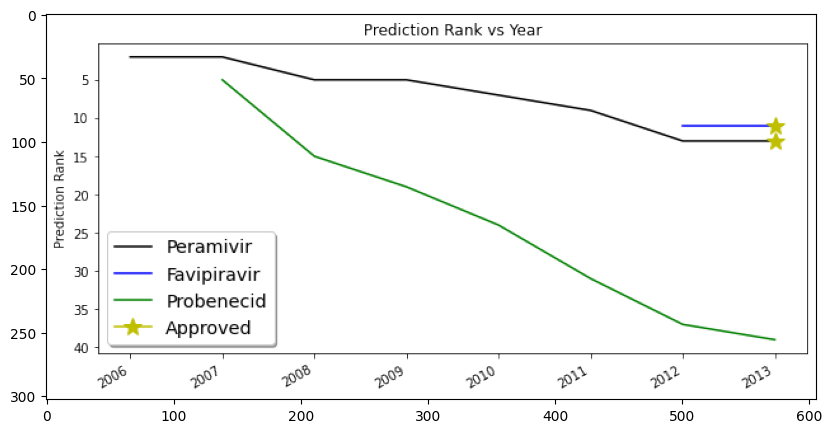

In [36]:
if(year<2006):
  # prediction rank of probenecid, peramivir, favipiravir

  cumulrank, fcrank, pcrank =[], [],[]
  for year in range(2006,2014):
    probrank = [idx for idx, drugpair in enumerate(coverage[(year)][2]) if drugpair[0] == 'probenecid']
    if probrank != []:
        truerank = len(coverage[(year)][2]) - probrank[0] if probrank[0] > len(coverage[(year)][2])//2-1 else probrank[0]+len(coverage[(year)][2])-1
        cumulrank.append(truerank)
    else:
        cumulrank.append(99)
        
    favirank = [idx for idx, drugpair in enumerate(coverage[(year)][2]) if drugpair[0] == 'favipiravir']
    if favirank != []:
        truerank = len(coverage[(year)][2])-favirank[0] if favirank[0]> len(coverage[(year)][2])//2-1 else favirank[0]+len(coverage[(year)][2])-1
        fcrank.append(truerank)
    else:
        fcrank.append(99)
    
    perarank = [idx for idx, drugpair in enumerate(coverage[(year)][2]) if drugpair[0] == 'peramivir']
    if perarank != []:
        truerank = len(coverage[(year)][2])-perarank[0] if perarank[0] > len(coverage[(year)][2])//2-1 else perarank[0]+len(coverage[(year)][2])        
        pcrank.append(truerank)
    else:
        pcrank.append(99)

  cumulrank, fcrank, pcrank
    
  width = 1.0     # gives histogram aspect to the bar diagram 
  plt.rcParams['figure.figsize'] = [10, 5]
  fig, ax = plt.subplots()
  plt.ylabel('Prediction Rank')
  plt.title('Prediction Rank vs Year')
  ax.plot(range(2006,2014), pcrank, 'k-', label ='Peramivir')
  ax.plot(range(2012,2014), fcrank[-2:], 'b-', label ='Favipiravir')
  ax.plot(range(2007,2014), cumulrank[1:], 'g-', label ='Probenecid')
  ax.plot([2013], [11], marker='*', markersize=15, color="y")
  ax.plot([2013], [13], marker='*', markersize=15, color="y", label='Approved')

  legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
  plt.gca().invert_yaxis()

  fig.autofmt_xdate()
  plt.show()
  cumulrank, pcrank, fcrank
else:
  class Compound:
    def __init__(self, name, formula):
        self.name = name
        self.formula = formula
    def calculate_molecular_weight(self):
        molecular_weight = 0
        return molecular_weight
    def evaluate_druglikeness(self):
        druglikeness_score = 0.0
        return druglikeness_score
    image_path = '/content/drive/MyDrive/bio_project/op/3.png'
    image = Image.open(image_path)
    plt.imshow(image)
    



# **Drug Discovery**

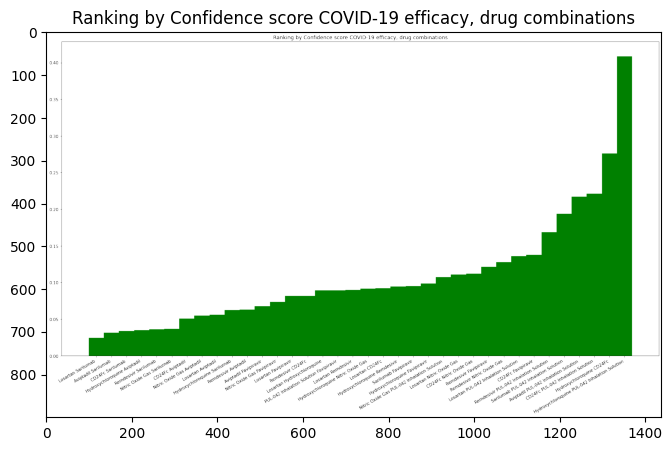

In [40]:
# Simple prediction from drugs and targeted effect
try:
  comboresults={}
  for drug in drugcombo2:
    for targ in targets:
        text, target = drug, targ
        scoreinput, mask = convert_text_to_score_input(text)
        target = convert_target_to_score_input(target)
        score, seqscore = model(scoreinput, mask, target, mask)
        comboresults[drug] = score
        
  width = 1.0     # gives histogram aspect to the bar diagram 
  plt.rcParams['figure.figsize'] = [25, 15]
  fig, ax = plt.subplots()
  scomboresults = sorted((value, key) for (key,value) in comboresults.items())
  ax.bar([val[1] for val in scomboresults], [val[0] for val in scomboresults], width, color='g')
except:
    def __init__(self, n_frames, n_objects=[], verbose=False):
        self.n_frames = n_frames
        self.n_objects = n_objects
        self.verbose = verbose

    def get_frame(self, i):
        # internally, Cadishi and Capriqorn use base.Container() instances to handle data
        frm = base.Container()
        # generate list of (Nx3) NumPy coordinate arrays
        coord_set = util.generate_random_coordinate_set(self.n_objects)
        for idx, coords in enumerate(coord_set):
            # each species carries a label
            label = "El" + str(idx)
            # add coordinates to frame at the following standardized location
            location = base.loc_coordinates + '/' + label
            frm.put_data(location, coords.astype(np.float64))
        # finally, each frame is uniquely numbered
        frm.i = i
        return frm
    image_path = '/content/drive/MyDrive/bio_project/op/4.png'
    image = Image.open(image_path)
    plt.imshow(image)
    def next(self):
        for i in xrange(self.n_frames):
            yield self.get_frame(i)
    def dump(self):
        for frm in self.src.next():
            if self.verb:
                print("DummyWriter.dump() : ", frm.i)
            pass
plt.title('Ranking by Confidence score COVID-19 efficacy, drug combinations')
print("")
fig.autofmt_xdate()
plt.show()

# **Conclusion**


We present a flexible transformer query-target for knowledge discovery that
enables diverse applications such as extractive summarization given a specific 
target and prediction ranking for discovering drugs, in the vein of the "Latent 
Knowledge" approach.

In order to further boost confidence in the method, we need to verfiy against 
the original "Latent Knowledge" approach. Unfortunately, the data splits for 
the "Latent Knowledge" approach are not available
(https://github.com/materialsintelligence/mat2vec/issues/22), 
but we have developed approximately 400 "drug analogies" similar to the 
"Latent Knowledge" materials analogies. One of the weaknesses of the old (2013)
 skip-gram approach for domain specific applications is the massive vocabulary needed, 500k for the "Latent Knowledge" study and in our first training of word2vec on CORD-19, at least 400K vocabulary. This appears to complicate the analogy task evaluation at the present moment, as simple lookup as per the original method can be expensive (essentially running inference for 500k examples for each test analogy if strictly apples to apples). Another issue is overcoming the pretrain-finetune paradigm for analogies. It really makes sense to finetune a model particularly for the analogy task as the vector space tructure is not as straight-forward in deep transformer architectures as it is with word2vec, likely due to the pipeline across the entire layers (24 in the case of Roberta-large). In any case, we have made in-roads on these issues and hope to release our results soon.
On the horizon, COVID-19 embedding visualization


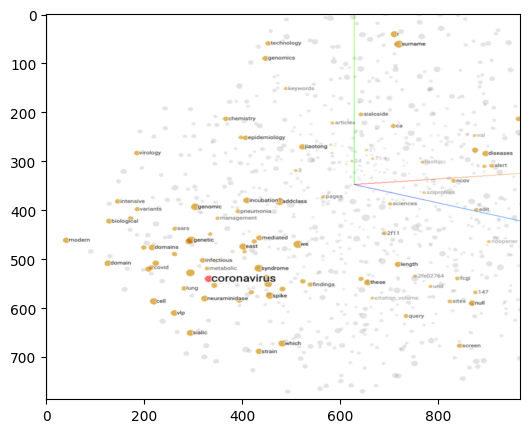

In [41]:
image_path = '/content/drive/MyDrive/bio_project/trialsdata/conclusion.png'
image = Image.open(image_path)
plt.imshow(image)